In [1]:
# using dev_model_arch
from module_model_architecture import get_data, setup_training, setup_training, plot_val_metrics, evalation_metrics, visualise_prediction_on_patch
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf
import pickle

Model architecture functions loaded successfully


In [2]:
patch_size = 256
image_channels = 1 #map converted to greyscale
batch_size = 10
epochs = 2
training_history = 'model-weights-and-training-history/training_history.pkl'
model_weights_path = 'model-weights-and-training-history/model_weights.weights.h5'

In [3]:
# Load TRAINING data
print("Loading training data...")
training_data_path = 'training-data/'
X_train, y_train = get_data(training_data_path, patch_size, image_channels, train=True)

print("Filtering out empty masks...")
non_empty_indices = [i for i in range(len(y_train)) if not np.all(y_train[i] == 0)]
X_train_filtered = X_train[non_empty_indices]
y_train_filtered = y_train[non_empty_indices]
print(f"Filtered training samples: {X_train_filtered.shape[0]}")

# Use X_train_filtered and y_train_filtered for train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_filtered, y_train_filtered, test_size=0.3, random_state=42
)
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_valid.shape[0]}")

# Setup model
print("Building model...")
model = setup_training(patch_size, image_channels)
#model.summary()

# Callbacks
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(model_weights_path, verbose=1, 
                   save_best_only=True, save_weights_only=True),
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
]

Loading training data...
Getting and resizing images...


100%|██████████| 1142/1142 [00:46<00:00, 24.43it/s]


Done!
Filtering out empty masks...
Filtered training samples: 699
Training samples: 489
Validation samples: 210
Building model...



In [4]:
# Train model
print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid),
    verbose=1
)

# Save training history
with open(training_history, 'wb') as f:
    pickle.dump(history.history, f)

# Clear memory
del X_train, y_train, X_valid, y_valid
tf.keras.backend.clear_session()
print("Training completed! Memory cleared.")

Starting training...
Epoch 1/2
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - dsc: 0.1686 - loss: 0.8314 - prec: 0.1065 - recall: 0.8754 - tn: 0.6765 - tp: 0.9081
Epoch 1: val_loss improved from None to 0.99807, saving model to model-weights-and-training-history/model_weights.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 57s 903ms/step - dsc: 0.3269 - loss: 0.6738 - prec: 0.2520 - recall: 0.8323 - tn: 0.8476 - tp: 0.8484 - val_dsc: 0.0019 - val_loss: 0.9981 - val_prec: 0.0406 - val_recall: 0.0010 - val_tn: 1.0000 - val_tp: 5.3205e-05 - learning_rate: 0.0010
Epoch 2/2
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - dsc: 0.7103 - loss: 0.2897 - prec: 0.6863 - recall: 0.7413 - tn: 0.9907 - tp: 0.7437
Epoch 2: val_loss did not improve from 0.99807
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 849ms/step - dsc: 0.7182 - loss: 0.2819 - prec: 0.6943 - recall: 0.7517 - tn: 0.9908 - tp: 0.7535 - val_dsc: 2.1978e-04 - val_loss: 0.9998 - val_prec: 0.0476 - val_recall: 1.3683e-04 - val_tn: 1.0000 - val_tp: 5.3205e-05 - learning_

In [ ]:
def evalation_metrics(model_weights_path, patch_size, image_channels):
    # Load the saved model
    print("Loading trained model...")
    model = build_attn_unet((patch_size, patch_size, image_channels), dice_loss)
    model.load_weights(model_weights_path)

    # Recompile with metrics
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss=dice_loss, 
                metrics=[dsc, tp, tn, prec, recall])

    # Load TEST data
    print("Loading test data...")
    path_test = '../training-data/test/'
    X_test, y_test = get_data(path_test, train=True)

    # Evaluate model
    print("Evaluating model...")
    test_loss, test_dsc, test_tp, test_tn, test_prec, test_recall = model.evaluate(
        X_test, y_test, batch_size=1, verbose=1
    )

    print(f"------------------")
    print(f"Test Results:")
    print(f"Dice Score: {test_dsc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"True Positive Rate: {test_tp:.4f}")
    print(f"True Negative Rate: {test_tn:.4f}")

    # Clear memory
    del X_test, y_test
    tf.keras.backend.clear_session()
    print("Evaluation completed! Memory cleared.")

In [3]:
evalation_metrics(model_weights_path, patch_size, image_channels)

Loading trained model...

Loading test data...
Getting and resizing images...


100%|██████████| 50/50 [00:01<00:00, 41.93it/s]


Done!
Evaluating model...
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - dsc: 0.0094 - loss: 0.9906 - prec: 0.0408 - recall: 0.4017 - tn: 1.0000 - tp: 0.4011
------------------
Test Results:
Dice Score: 0.0094
Precision: 0.0408
Recall: 0.4017
True Positive Rate: 0.4011
True Negative Rate: 1.0000
Evaluation completed! Memory cleared.


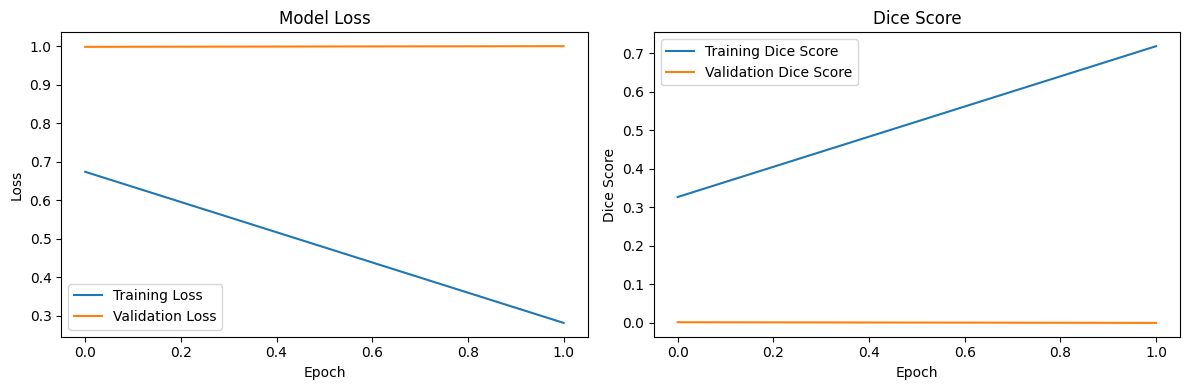

Plotting completed!


In [5]:
plot_val_metrics(training_history)

Loading trained model...

Loading image: training-data/test/images/Wootton_Courtney_5_27.png
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


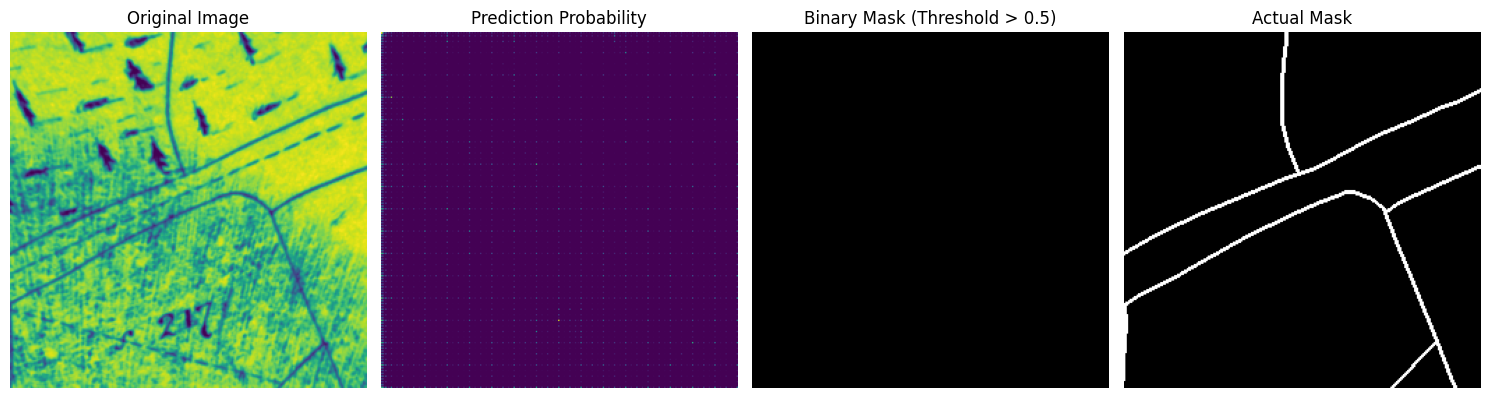

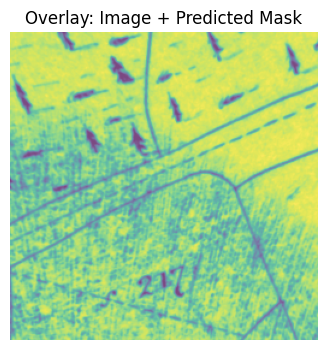

In [ ]:
test_image = "Wootton_Courtney_5_27" # change this to a patch's name 
prediction, binary_mask = visualise_prediction_on_patch(patch_size, image_channels, model_weights_path, test_image)